In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.15.0'

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Getting the data

!kaggle datasets download -d muratkokludataset/rice-image-dataset

 96% 210M/219M [00:02<00:00, 120MB/s] 
100% 219M/219M [00:02<00:00, 98.6MB/s]


In [5]:
from zipfile import ZipFile

def unzip_data(path : str) -> None:
  zf_ref = ZipFile(path)
  zf_ref.extractall()
  zf_ref.close()

filepath = 'rice-image-dataset.zip'
unzip_data(filepath)

In [6]:
# Creating Train Val Test datas
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32
img_height = 128
img_width = 128

train_data, val_data = image_dataset_from_directory('Rice_Image_Dataset',
                                          label_mode = 'categorical',
                                          image_size = (img_height, img_width),
                                          seed = 42,
                                          validation_split = 0.2,
                                          subset = 'both')


Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Using 15000 files for validation.


In [9]:
class_names = train_data.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [8]:
# Creating Models

# Model 1 : TinyVGG
# Model 2 : ResNet
# Model 3 : EfficientNet

In [60]:
# TinyVgg Model
input = layers.Input(shape=(img_height, img_width, 3))
x = layers.Rescaling(scale=1./255) ( input)
x = layers.Conv2D( filters = 8,
                  kernel_size = 2,
                  activation= 'relu') ( x )
x = layers.Conv2D(filters = 8,
                  kernel_size = 2,
                  activation= 'relu') ( x )
x = layers.MaxPool2D() ( x )
x = layers.Conv2D(filters = 16,
                  kernel_size = 2,
                  activation= 'relu') ( x )
x = layers.Conv2D(filters = 16,
                  kernel_size = 2,
                  activation= 'relu') ( x )
x = layers.MaxPool2D() ( x )
x = layers.Flatten () ( x )
output = layers.Dense( len(class_names), activation = 'softmax') ( x )



model_0 = tf.keras.Model( input, output )
model_0.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 127, 127, 8)       104       
                                                                 
 conv2d_28 (Conv2D)          (None, 126, 126, 8)       264       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 62, 62, 16)        528       
                                                          

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_path = 'model/ckpt/'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [61]:

model_0.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


model_history = model_0.fit(train_data,
            epochs=5,
            steps_per_epoch = int(len(train_data)),
            validation_data = val_data,
            validation_steps = int(0.1*len(val_data)),
            callbacks = [model_checkpoint])

Epoch 1/5
1875/1875 [==============================] - 43s 21ms/step - loss: 0.1440 - accuracy: 0.9518 - val_loss: 0.0744 - val_accuracy: 0.9742
Epoch 2/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0697 - accuracy: 0.9767 - val_loss: 0.0366 - val_accuracy: 0.9871
Epoch 3/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.0231 - val_accuracy: 0.9912
Epoch 4/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 0.0136 - val_accuracy: 0.9966
Epoch 5/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0155 - val_accuracy: 0.9946


In [62]:
model_0.evaluate(val_data)

469/469 [==============================] - 9s 19ms/step - loss: 0.0188 - accuracy: 0.9939


[0.01876956596970558, 0.9939333200454712]

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curve(model_history) -> None:
  df = pd.DataFrame(model_history.history)

  df[['loss', 'val_loss']].plot()
  plt.title('Model Loss')

  df[['accuracy', 'val_accuracy']].plot()
  plt.title('Model Accuracy')



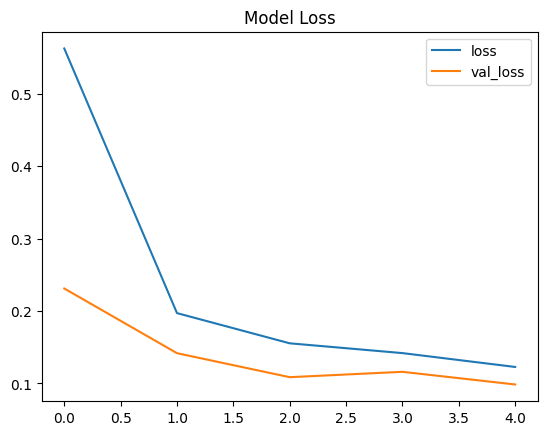

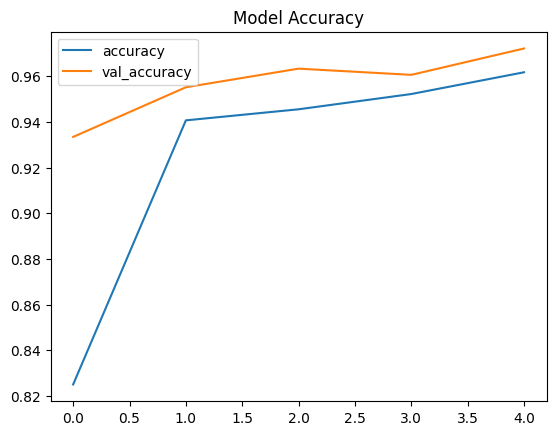

In [44]:
plot_loss_curve(model_history)

In [63]:
# Model 2 : ResNet
from tensorflow.keras.applications import ResNet50V2


base = ResNet50V2(include_top = False)
base.trainable = False

input = layers.Input(shape=(img_height, img_width, 3))
x = layers.Rescaling(scale=1./255) ( input)
x = base ( x )
x = layers.Flatten()(x)
output = layers.Dense( len(class_names), activation = 'softmax') ( x )



model_1 = tf.keras.Model( input, output )
model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 flatten_11 (Flatten)        (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 5)                 163845    
                                                                 
Total params: 23728645 (90.52 MB)
Trainable params: 163845 (640.02 KB)
Non-trainable params: 23564800 (89.89 MB)
___________

In [64]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


model_history = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch = int(len(train_data)),
            validation_data = val_data,
            validation_steps = int(0.1*len(val_data)),
            callbacks = [model_checkpoint])

Epoch 1/5
1875/1875 [==============================] - 67s 34ms/step - loss: 0.3334 - accuracy: 0.9651 - val_loss: 0.1844 - val_accuracy: 0.9871
Epoch 2/5
1875/1875 [==============================] - 63s 33ms/step - loss: 0.2501 - accuracy: 0.9834 - val_loss: 0.2599 - val_accuracy: 0.9857
Epoch 3/5
1875/1875 [==============================] - 64s 34ms/step - loss: 0.2044 - accuracy: 0.9880 - val_loss: 0.3695 - val_accuracy: 0.9830
Epoch 4/5
1875/1875 [==============================] - 64s 34ms/step - loss: 0.2145 - accuracy: 0.9886 - val_loss: 0.1892 - val_accuracy: 0.9932
Epoch 5/5
1875/1875 [==============================] - 63s 33ms/step - loss: 0.1770 - accuracy: 0.9913 - val_loss: 0.1610 - val_accuracy: 0.9939


In [65]:
model_1.evaluate(val_data)

469/469 [==============================] - 17s 36ms/step - loss: 0.2471 - accuracy: 0.9906


[0.24711406230926514, 0.9905999898910522]

In [54]:
# Model 3 : EfficientNet
from tensorflow.keras.applications import EfficientNetV2B0


base = EfficientNetV2B0( include_top = False )
base.trainable = False

input = layers.Input(shape=(img_height, img_width, 3))
x = base ( input )
x = layers.Flatten()(x)
output = layers.Dense( len(class_names), activation = 'softmax') ( x )
model_2 = tf.keras.Model( input, output )
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 flatten_9 (Flatten)         (None, 20480)             0         
                                                                 
 dense_10 (Dense)            (None, 5)                 102405    
                                                                 
Total params: 6021717 (22.97 MB)
Trainable params: 102405 (400.02 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [55]:
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


model_history = model_2.fit(train_data,
            epochs=5,
            steps_per_epoch = int(len(train_data)),
            validation_data = val_data,
            validation_steps = int(0.1*len(val_data)),
            callbacks = [model_checkpoint])

Epoch 1/5
1875/1875 [==============================] - 61s 28ms/step - loss: 0.0751 - accuracy: 0.9816 - val_loss: 0.0451 - val_accuracy: 0.9939
Epoch 2/5
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0690 - accuracy: 0.9893 - val_loss: 0.0476 - val_accuracy: 0.9952
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0633 - accuracy: 0.9916 - val_loss: 0.0401 - val_accuracy: 0.9980
Epoch 4/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0567 - accuracy: 0.9930 - val_loss: 0.0589 - val_accuracy: 0.9952
Epoch 5/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0540 - accuracy: 0.9938 - val_loss: 0.0540 - val_accuracy: 0.9959


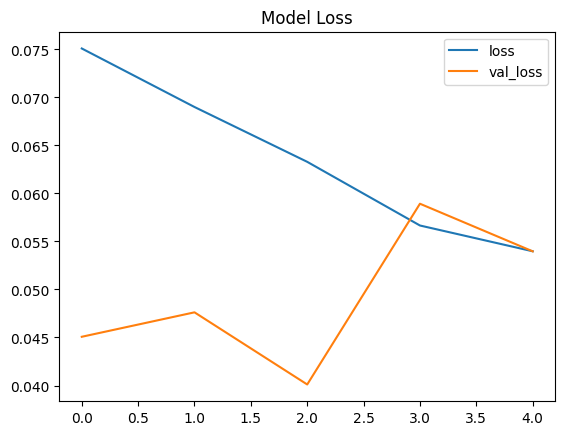

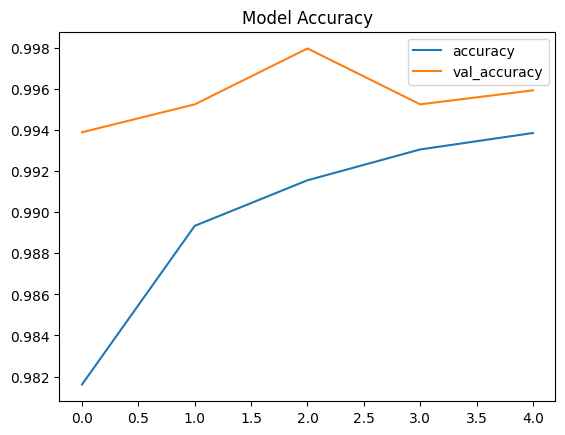

In [56]:
plot_loss_curve(model_history)

In [59]:
model_2.evaluate(val_data)

469/469 [==============================] - 14s 30ms/step - loss: 0.0381 - accuracy: 0.9965


[0.03813846409320831, 0.9964666962623596]